In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
def empirical_response(empirical_resp, stim_vals, x, stretch=1):
    stim_vals = stim_vals*stretch
    X = []
    for val in x:
        X.append(np.argmin(np.abs(stim_vals-val)))
    return empirical_resp[X]

def make_noise(exp_stim_resp, stim_num_vals, exp_stim_trials):
    exp_stim_resp_noise = np.random.normal(scale=0.1, size=(stim_num_vals, exp_stim_trials))
    noise_mask = np.expand_dims(np.abs(np.abs(exp_stim_resp-0.5)-0.5) ,axis=1)
    return np.multiply(exp_stim_resp_noise, np.repeat(noise_mask, exp_stim_trials, axis=1))

def compute_entropy(probs):
    return -probs @ np.log2(probs)

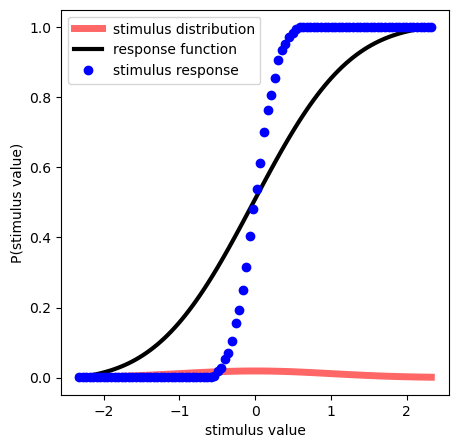

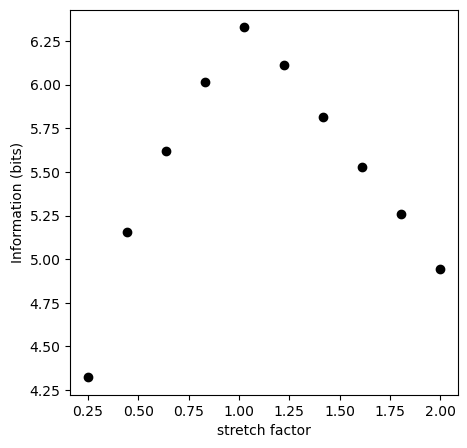

In [3]:
stim_num_vals = 100
stim_vals = np.linspace(sp.stats.norm.ppf(0.01), sp.stats.norm.ppf(0.99), stim_num_vals)
stim_dist = sp.stats.norm.pdf(stim_vals)/np.sum(sp.stats.norm.pdf(stim_vals))
empirical_resp = np.cumsum(stim_dist)
exp_stim_trials = 1000
exp_stim_vals = stim_vals
exp_stim_resp = empirical_response(empirical_resp, stim_vals, exp_stim_vals, stretch=0.25)
exp_stim_resp_noise = make_noise(exp_stim_resp, stim_num_vals, exp_stim_trials)

plt.figure(figsize=(5, 5))
plt.plot(stim_vals, stim_dist, 'r-', lw=5, alpha=0.6, label='stimulus distribution')
plt.plot(stim_vals, empirical_resp, 'k-', lw=3, label='response function')
plt.plot(exp_stim_vals, exp_stim_resp, 'bo', lw=3, label='stimulus response')
plt.xlabel("stimulus value")
plt.ylabel("P(stimulus value)")
plt.legend()
plt.show()

# Show the information as a function of the stretch factor
stretch_factors = np.linspace(1/4, 2, 10)
entropies = np.zeros((len(stretch_factors),))

for i, stretch in enumerate(stretch_factors):
    exp_stim_resp = empirical_response(empirical_resp, stim_vals, exp_stim_vals, stretch=stretch)
    prob_stim_resp = np.diff(np.hstack((np.array(0), exp_stim_resp)))
    # to remove P = 0
    nonzero_idx = prob_stim_resp>0
    entropies[i] = compute_entropy(prob_stim_resp[nonzero_idx])

plt.figure(figsize=(5,5))
plt.plot(stretch_factors, entropies, 'ko', lw=3)
plt.xlabel("stretch factor")
plt.ylabel("Information (bits)")
plt.show()

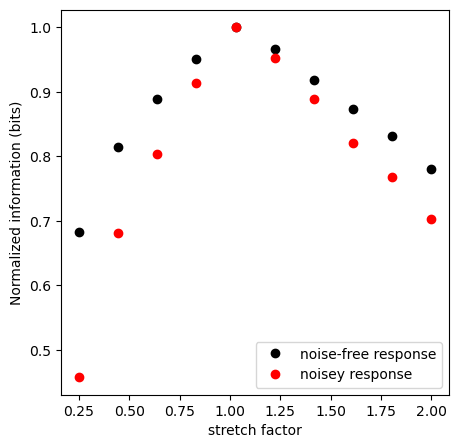

In [4]:
# Show the information as a function of the stretch factor
stretch_factors = np.linspace(1/4, 2, 10)
entropies_noise = np.zeros((len(stretch_factors),))

for istretch, stretch in enumerate(stretch_factors):
    # compute the information with the noise distribution conditional on the mean response
    exp_stim_resp = empirical_response(empirical_resp, stim_vals, exp_stim_vals, stretch=stretch)
    exp_noise = make_noise(exp_stim_resp, stim_num_vals, exp_stim_trials)
    # compute the probabilities
    prob_stim_resp = np.diff(np.hstack((np.array(0), exp_stim_resp)))
    # compute the entropy
    noise_term = 0
    for i in range(stim_num_vals):
        counts, _ = np.histogram(exp_noise[i,:])
        prob_noise = counts/np.sum(counts)
        nonzero_idx = prob_noise>0
        noise_term += prob_stim_resp[i]*compute_entropy(prob_noise[nonzero_idx])
    # to remove P = 0
    nonzero_idx = prob_stim_resp>0
    entropies_noise[istretch] = compute_entropy(prob_stim_resp[nonzero_idx]) - noise_term

plt.figure(figsize=(5,5))
plt.plot(stretch_factors, entropies/np.max(entropies), 'ko', lw=3, label='noise-free response')
plt.plot(stretch_factors, entropies_noise/np.max(entropies_noise), 'ro', lw=3, label='noisey response')
plt.xlabel("stretch factor")
plt.ylabel("Normalized information (bits)")
plt.legend()
plt.show()